In [6]:
import pandas as pd
import numpy as np

Read Data into python and clean columnames

In [ ]:
# data=pd.read_csv('Fire_Department_Calls_for_Service_0.csv')  
# transformation of time variables for this file took 1 h

data=pd.read_csv('Fire_Department_Calls_for_Service_2.csv')
data.columns = [x.lower().replace(' ','_').replace('-','') for x in data.columns]
data.shape

### Changing Types

In [ ]:
data.dtypes


all time variables are saved as objects => format change

In [ ]:
from datetime import datetime

timel=['call_date', 'watch_date', 'received_dttm', 'entry_dttm', 'dispatch_dttm',
       'response_dttm', 'on_scene_dttm', 'transport_dttm', 'hospital_dttm', 'available_dttm']
for t in timel:
       data[t]=pd.to_datetime(data[t])
       print(t)
data.head(4).T

### Dealing with Priority


In [ ]:
display(data.original_priority.value_counts(dropna=False))
display(data.priority.value_counts(dropna=False))
display(data.final_priority.value_counts(dropna=False))

Acording to the Data Dictionary follows that 3 means Emergency and 2 means and 3 means non-Emergency
other types are nogt listed in the dictionary

It is to mention that also the numbers in `original_priority` and  `priority` are saved as str and that the values in `final_priority` are saved as int. So this must be included inside the decoder.

In [ ]:
def prio(x):
    if x in ['3', 3]:
        return 'Emergency'
    elif x in ['2', 2]:
        return 'non-Emergency' 
    else:
        return 'not known' 


data.original_priority=data.original_priority.apply(prio)
data.final_priority=data.final_priority.apply(prio)
data.priority=data.priority.apply(prio)
data.head(4).T

### City cleaning

In [ ]:
data.city.value_counts(dropna=False)

The format of `city` changed during time. (Can be seen by filtering for different years). This results in a list of different names for the same city. 
This will be fixed in this step.

In [ ]:
def cnames(x):
    if x in ['SF','San Francisco','SAN FRANCISCO','SFO']:
        return 'San Francisco'
    elif x in ['TI','Treasure Isla', 'Treasure Island','TREASURE ISLAND']:
        return 'Treasure Island'
    elif x in ['Presidio','PR', 'PRESIDIO']:
        return 'Presidio'
    elif x in ['Yerba Buena', 'YB', 'YERBA BUENA IS']:
        return 'Yerba Buena'
    elif x in ['Hunters Point', 'HP', 'HUNTERS POINT']:
        return 'Hunters Point'
    elif x in ['Fort Mason', 'FM', 'Fort Mason', 'FORT MASON']:
        return 'Fort Mason'
    elif x in ['DC', 'Daly City','DALY CITY']:
        return 'Daly City'
    elif x in ['BN', 'Brisbane']:
        return 'Brisbane'
    elif x in ['OAK','Oakland']:
        return 'Oakland'
    elif x in ['AI','Angel Island']:
        return 'Angel Island'

data.city=data.city.apply(cnames)
data.city.value_counts(dropna=False)

The format of `box` is not consistent and incluedse ints, floats and strings. The direct transformation results to different errors.

In [ ]:
def boxtype(x):
    if (type(x)== float) & (x==x):# change to int (second condition will be used  due to problems with nan)
        x = int(x)
    if type(x) == int:
        x = str(x)
    return x #output should be string (due to existinfg box numbers like 0231)

print(len(data.box.unique()))
data.box=data.box.apply(boxtype)
print(len(data.box.unique()))


`case_location` has the format: 'POINT (longitude latitude)'

Get new columns with longitude and latitude

In [ ]:
def locdecode_lo(x):
    #string operations throws errors if there will be used on NaNs
    if x==x:
        u=x.split() #split into [ POINT, (longitude , latitude) ]
        longitude = float(u[1][1:]) # second brackets will be used to exlude the brackets '(' and ')' 
        latitude = float(u[2][:-1])
        return longitude
def locdecode_la(x):
    #string operations throws errors if there will be used on NaNs
    if x==x:
        u=x.split() #split into [ POINT, (longitude , latitude) ]
        longitude = float(u[1][1:]) # second brackets will be used to exlude the brackets '(' and ')' 
        latitude = float(u[2][:-1])
        return latitude

# make an apply function which works on the row, to create the lonigtude and latitude column at once takes much longer as running these two functions
data['longitude']=data.case_location.apply(locdecode_lo)
data['latitude']=data.case_location.apply(locdecode_la)
data.head().T

### Dealing with NaN

In [ ]:
data.isna().sum()

If `case_location` is not known and so the `longitude` and `latitude`, we can look on other incidence at the same address 

In [ ]:
data[data.case_location.isna()].address.value_counts(dropna=False)
data[data.address == '1700 Block of MARKET ST'].case_location.value_counts(dropna=False)

specially for the summed up addresses like 'x Block of h Street' there exist multiple similiar  coordinates. Try to get coordinates by computing the mean location of the address 

In [ ]:
#def locfill(u,address):
data2=data[data.longitude.isna()].copy()
def locfill(row):
    row.longitude=data[data.address == row.address].longitude.mean()
    row.latitude=data[data.address == row.address].latitude.mean()
    return row


data2=data2.apply(locfill,axis=1)
data2.head().T


In [ ]:
data[data.longitude.isna()]=data2
data.isna().sum()

In [ ]:
display(data[data.longitude.isna()].address)
data[data.address == '1800 Block of BLK EVANS AV'].longitude.value_counts(dropna=False)

In [ ]:
# the last 6 entries without gps does not have data to compare => drop it

data=data[~data.longitude.isna()]
data.isna().sum()

In [ ]:
data.to_csv('Fire_Department_Calls_for_Service_2.csv', index=False)

data[data.box.isna()].address.value_counts()

### Analysation

In [8]:
data=pd.read_csv('Fire_Department_Calls_for_Service_2.csv')


C:\Users\lahrm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,25,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
data.call_final_disposition.value_counts(dropna=False)

Other                         2536699
Code 2 Transport              1677835
Fire                           762919
Patient Declined Transport     207583
No Merit                       184125
Code 3 Transport               143886
Cancelled                       61535
Against Medical Advice          60287
Unable to Locate                57813
Medical Examiner                43139
SFPD                            29225
Gone on Arrival                 17340
Duplicate                        1370
CHP                               935
Multi-casualty Incident           294
Name: call_final_disposition, dtype: int64

In [10]:
from datetime import datetime

timel=['call_date', 'watch_date', 'received_dttm', 'entry_dttm', 'dispatch_dttm',
       'response_dttm', 'on_scene_dttm', 'transport_dttm', 'hospital_dttm', 'available_dttm']
for t in timel:
       data[t]=pd.to_datetime(data[t])
       print(t)

call_date
watch_date
received_dttm
entry_dttm
dispatch_dttm
response_dttm
on_scene_dttm
transport_dttm
hospital_dttm
available_dttm


Getting time variables for grooping

In [11]:
data['iyear']=data.call_date.apply(lambda x: x.year)
data['iweekday']=data.call_date.apply(lambda x: x.weekday())
data['imonth']=data.call_date.apply(lambda x: x.month)
data.head(4).T

,0,1,2,3
call_number,211220229,213150159,210690030,210391607
unit_id,54,T13,T03,E19
incident_number,21052265,21138532,21030278,21017645
call_type,Medical Incident,Alarms,Alarms,Alarms
call_date,2021-05-02 00:00:00,2021-11-11 00:00:00,2021-03-10 00:00:00,2021-02-08 00:00:00
watch_date,2021-05-01 00:00:00,2021-11-10 00:00:00,2021-03-09 00:00:00,2021-02-08 00:00:00
received_dttm,2021-05-02 02:52:22,2021-11-11 01:45:25,2021-03-10 00:16:03,2021-02-08 13:00:14
entry_dttm,2021-05-02 02:54:09,2021-11-11 01:46:46,2021-03-10 00:18:36,2021-02-08 13:01:36
dispatch_dttm,2021-05-02 02:54:17,2021-11-11 01:47:12,2021-03-10 00:19:01,2021-02-08 13:01:40
response_dttm,2021-05-02 02:54:22,2021-11-11 01:49:56,2021-03-10 00:20:15,2021-02-08 13:03:21


Look the number of calls at different weekdays 

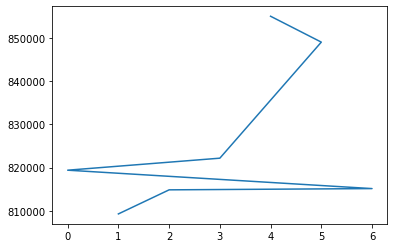

4    855033
5    849044
3    822190
0    819410
6    815153
2    814863
1    809292
Name: iweekday, dtype: int64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

weekday_data=data.iweekday.value_counts()

plt.plot(weekday_data)
plt.show()
weekday_data

<AxesSubplot:xlabel='call_date'>

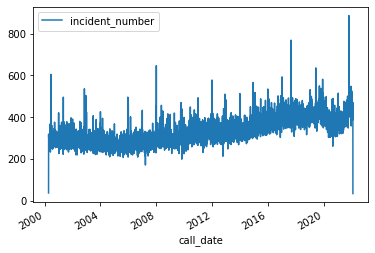

In [13]:
daycount=pd.pivot_table(data,index='call_date',values='incident_number', aggfunc=lambda x: len(x.unique()))
daycount.plot()

In [14]:
daycount=daycount.rename(columns={'incident_number': 'number_of_incidents'})
daycount=daycount.reset_index()
daycount

,call_date,number_of_incidents
0,2000-04-12,37
1,2000-04-13,252
2,2000-04-14,319
3,2000-04-15,286
4,2000-04-16,303
...,...,...
7965,2022-02-03,451
7966,2022-02-04,471
7967,2022-02-05,446
7968,2022-02-06,425


In [ ]:
daycount.to_excel('Fire_Department_Calls_for_Service_daycount.xlsx',index=False)

In [15]:
data.city.value_counts()

San Francisco      5717350
Treasure Island      25555
Presidio             22372
Yerba Buena           3229
Fort Mason            3141
Hunters Point         2391
Daly City             1617
Brisbane               449
Oakland                244
Angel Island            35
Name: city, dtype: int64

### Dealing with the other NANs

In [16]:
data.isna().sum()

call_number                                  0
unit_id                                      0
incident_number                              0
call_type                                    0
call_date                                    0
watch_date                                   0
received_dttm                                0
entry_dttm                                   0
dispatch_dttm                                0
response_dttm                           427320
on_scene_dttm                          1288700
transport_dttm                         4260632
hospital_dttm                          4397052
call_final_disposition                       0
available_dttm                           77072
address                                      0
city                                      8602
zipcode_of_incident                      14653
battalion                                    0
station_area                              2397
box                                        465
original_prio

In general all missing time-variables can't be filled rational or a filling of these fields does not make sense (patient transport time for a firetruck).


For area specific variables like `city`,`zipcode_of_incident` and `station_area` there exist two methodes how the NANs can be filled. 
1. Use a saved map and the `case_locations` (`longitude` and `latitude` coordinates) to get the missing entries of the these entries.
1. Using KNN-models to fill the missing entries with the value of the next neighbors.  

Because of the big size of the dataset the implementation would take too much time for this project.

`call_type_group` should correlate with the `call_type`. But a first comparison with value_count() of the different `call_type_groups` seems that the distribution of this variable is to random and the number of NANs to big so that the sinfull filling of the entries can't made in a first instance. So here this variable will be not used.

`unit_sequence_in_call_dispatch` refers to the order of the units on which they were called to the incident. In this case the NANs can be filled with a 1.

In [22]:
data.unit_sequence_in_call_dispatch=data.unit_sequence_in_call_dispatch.fillna(1)
data.isna().sum()

call_number                                  0
unit_id                                      0
incident_number                              0
call_type                                    0
call_date                                    0
watch_date                                   0
received_dttm                                0
entry_dttm                                   0
dispatch_dttm                                0
response_dttm                           427320
on_scene_dttm                          1288700
transport_dttm                         4260632
hospital_dttm                          4397052
call_final_disposition                       0
available_dttm                           77072
address                                      0
city                                      8602
zipcode_of_incident                      14653
battalion                                    0
station_area                              2397
box                                        465
original_prio

### Hypothesis Test

In this project there were no special question, that had to be answered. So here for an example it will be looked if between call and entrence of help takes less then 8 minutes.

In [23]:
data2=data[~data.on_scene_dttm.isna()]

In [31]:
data2['deltime']=data2.on_scene_dttm-data2.received_dttm
data2.deltime.apply(lambda x: x.total_seconds()//60).head()

C:\Users\lahrm\AppData\Local\Temp/ipykernel_1552/1085763585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['deltime']=data2.on_scene_dttm-data2.received_dttm


0    11.0
1     8.0
3     5.0
4     6.0
5     6.0
Name: deltime, dtype: float64

In [34]:
from scipy.stats import ttest_1samp
stat, pval = ttest_1samp(data2.deltime.apply(lambda x: x.total_seconds()//60),8)
print('stat:',stat)
print('pval:',pval)
data2.deltime.apply(lambda x: x.total_seconds()//60).mean()

stat: 8.027938650787862
pval: 9.914762345619455e-16


8.337783970544573

We can disprove that the Fire Department of San Francisco can garantue a entrence time of less then 8 minutes. But here we also include the entrance time of the 2nd, 3rd, 4th ... car and the fact that if a incident does not have a high priority, the fire trucks and ambulence cars drive slover.